## Question based EDA of m5 Competition - Beginners Guide ##

This guide will walk you through each aspect of the dataset and begin exploring questions to generate hypotheses for your ML workflow.  

Remember to implement these best practices:
* We will be going over it here, but [check out the detailed pdf on this competition.](https://mk0mcompetitiont8ake.kinstacdn.com/wp-content/uploads/2020/02/M5-Competitors-Guide_Final-1.pdf)
* Glean insights from previous competitions that are similar to this one.
* Read the discussion board for ideas and insights from those generous souls publishing their ideas.
* Get to know the data inside and out.
* Check out the pandas profiles I put up in this kernel [https://www.kaggle.com/tpmeli/simple-pandas-profiling-eda-for-starting-out](https://www.kaggle.com/tpmeli/simple-pandas-profiling-eda-for-starting-out)

### *This is just getting started - please upvote and link to this kernel if you use a portion of my work or if you'd like me to continue making it public.  Thanks!* ###

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from IPython.display import HTML

from tqdm import tqdm

%matplotlib inline
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams['axes.titlesize'] = 16

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5-untuned-sarima-preds/Sarima_preds_submission.csv
/kaggle/input/m5-pandas-profiles-of-sell-prices-calendar/calendar_report.html
/kaggle/input/m5-pandas-profiles-of-sell-prices-calendar/sell_prices_report.html
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv


**Read in the data for analysis**

In [2]:
train_sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
submission_file = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')

## What is intermittancy in a time series and why does it matter? ##

Intermittancy matters for several reasons:
* Sparse data sets have high dimensionality and this influences the effectiveness of various models.
* The evaluation metric (𝑹𝑴𝑺𝑺𝑬 - discussed soon) will take this into account so we can't get a high acccuracy by guessing a lot of 0's.

## The Train_Sales Dataset ##

![https://www.thomasmeli.com/wp-content/uploads/2020/03/Annotated-ID.png](https://www.thomasmeli.com/wp-content/uploads/2020/03/Annotated-ID.png)

"Contains the historical daily unit sales data per product and store"
It looks like it has 1907 days of store sale records.


In [3]:
print(train_sales.shape)
train_sales.sample(2)

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
7166,HOUSEHOLD_1_513_CA_3_validation,HOUSEHOLD_1_513,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,0,0,0,0,...,2,5,3,3,2,1,2,1,3,2
10599,HOUSEHOLD_2_357_CA_4_validation,HOUSEHOLD_2_357,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,0,1,1,1,0,0,0,1,0


## Calendar Dataset and its relationship with the sales dataset ##
![https://www.thomasmeli.com/wp-content/uploads/2020/03/Calendar-Dataset-Explanation.png](https://www.thomasmeli.com/wp-content/uploads/2020/03/Calendar-Dataset-Explanation.png)

## Creating 'Tidy' Dataframes Capable of being fed into Models ##
As it stands, this code makes the Kernel crash due to memory constraints.  Therefore, I created these dataframes offline
and will upload them when they are complete.  However, in order to see the code I used, I have included it below.

### Reveal Code To See How to Create a Tidy ML Ready DF ###

In [4]:
CREATE_TIDY_DF = False  # We will not create the tidy DF here.  Offline instead due to memory constraints.
LOAD_TIDY_DF = True  # When done, it will load externally for ease instead of processing in the kernel.

In [5]:
if CREATE_TIDY_DF:
    # Create a list comprehension for all the date columns to melt.
    d_cols = ['d_' + str(i + 1) for i in range(1913)]

    # Melt columns into rows so that each row is a separate and discrete entry with one target
    tidy_df = pd.melt(frame = train_sales, 
                     id_vars = ['id', 'item_id', 'cat_id', 'store_id'],
                     var_name = 'd',
                     value_vars = d_cols,
                     value_name = 'sales')

    # This has duplicate ID's now.  We should add the date to the id to make each row unique.
    new_ids = tidy_df['id'] + '_' + tidy_df['d']
    tidy_df['id'] = new_ids

    # Check this turned out ok so far.
    tidy_df.head()

In [6]:
if CREATE_TIDY_DF:
    # Merge the prices.  
    # NOTE - For now we are aggregating on the mean price of each item.
    # TO DO: We will want to set the price with the week or run some statistics on price volatility over time.

    price_means = sell_prices.groupby(['item_id']).mean()
    
    # Now, merge this and the date col
    with_prices_df = pd.merge(left = tidy_df, right = calendar,
                            on = 'd')

    with_prices_df.head(10)
    # Let's see the results.

In [7]:
if CREATE_TIDY_DF:
    with_date_info_df = pd.merge(left = with_prices_df, right = price_means,
                            on = 'item_id')
    
    total_tidy_df = with_date_info_df
    total_tidy_df.columns
    
    # Drop d and drop item_id (price is an informative proxy)
    total_tidy_df.drop(['d', 'wday', 'item_id'], axis = 1, inplace = True)
    
    # fill categorical NaNs with 0's.
    total_tidy_df = total_tidy_df.fillna(0)
    
    print(with_date_info_df.iloc[0])



**Price should be a good proxy for item_id and gives it a numerical value instead of a categorical value**
Once price is merged, we can drop item_id.  

We can also categorically encode store ID and cat_id.

In [8]:
if CREATE_TIDY_DF:
    
    # Categorical encoded column helper function.
    def categorically_encode_col(df, col):
        encoded_df = pd.get_dummies(df[col], 
                                    prefix = str(col),
                                   drop_first = False)

        return encoded_df
    
    total_tidy_df.columns

# Categorically encode the categorical columns and then drop the originals.
# This makes them ML ready.

if CREATE_TIDY_DF:
    
    # Categorically encode categorical columns
    cols_to_encode = ['cat_id', 'store_id', 'weekday', 'event_type_1', 'event_type_2' ]
    
    for col in cols_to_encode:
        new_cols = pd.DataFrame(categorically_encode_col(total_tidy_df, col))
        total_tidy_df = pd.concat([total_tidy_df, new_cols], axis = 1)
        # total_tidy_df.drop(col, inplace = True)  # Drop the un-encoded column

In [9]:
if CREATE_TIDY_DF:
    total_tidy_df.columns

In [10]:
if CREATE_TIDY_DF:
    # Export if necessary
    total_tidy_df.to_csv('total_tidy_df.csv')

## Question Based Exploratory Data Analysis ##

### How Do Sales Differ By Department?  Foods and household supplies are highest. ###

**Plotting Helper Functions**

In [11]:
def disp_boxplot(data, title, xlabel, ylabel):
    sns.set_style('whitegrid')
    sns.set_context('poster')
    palette = sns.color_palette("mako_r", 6)
    
    ax = sns.boxplot(data=data, palette = palette)
    ax.set(title = title,
          xlabel = xlabel,
          ylabel = ylabel)
    
    try:
        ax.axhline(y = data.mean().mean(), color = 'b', label = 'Mean of all datapoints', linestyle = '--', linewidth = 1.5)
        ax.ahline(y = data.median().median(), color = 'g', label = 'Median of all datapoints', linestyle = '--', linewidth = 1.5)
    except:
        pass
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    
    plt.legend()
    plt.show()

## How do sales differ by department? ##

In [12]:
dept_sales = train_sales.groupby(['dept_id']).mean().mean()
dept_sum = train_sales.groupby(['dept_id']).sum().T.reset_index(drop = True)

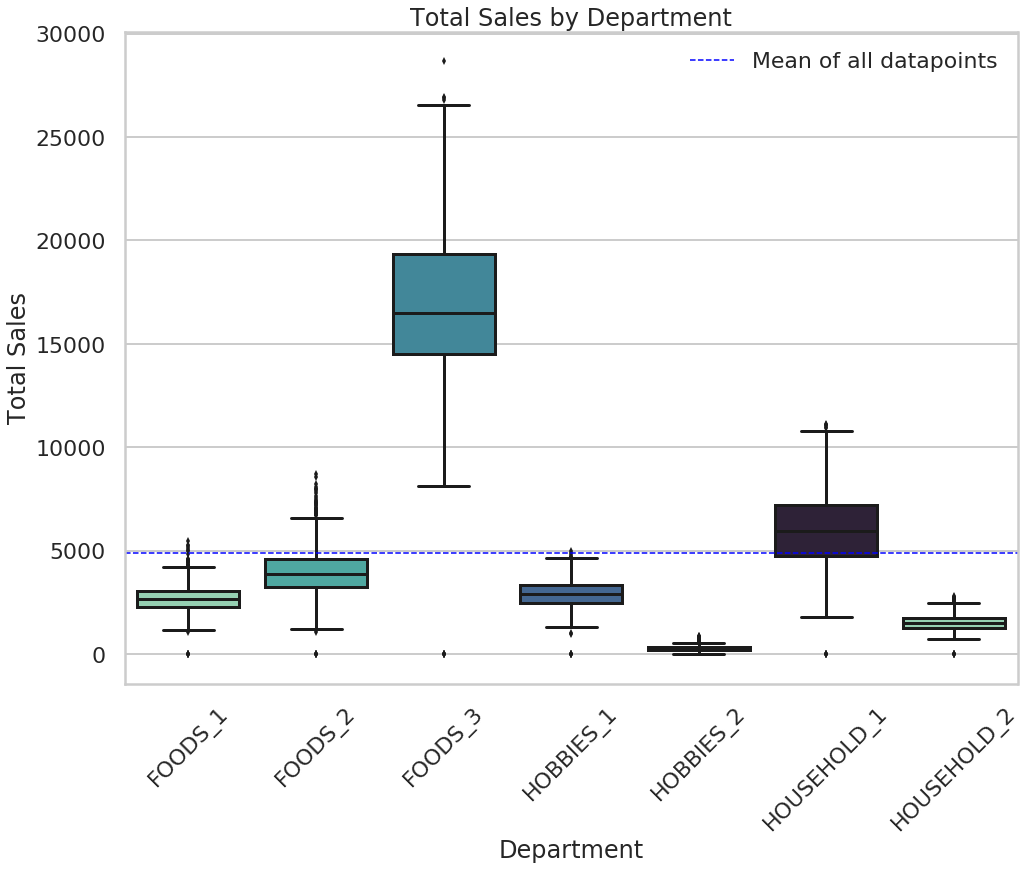

In [13]:
disp_boxplot(data = dept_sum, title = 'Total Sales by Department',
            xlabel = "Department", ylabel = "Total Sales")

### Do stores sell different kinds of items? Nope - All stores have the same kind of items ###
Above we can see that Foods_3 category and household_1 make the most total sales.  If stores have more of one type of item than another, their sales might be influenced by what items they stock the stores with.  Let's check to see if they have different amounts of items in each store.

Let's just make sure that all stores have the same categories and aren't selling more of one category or another.

store_id     CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3
dept_id                                                                
FOODS_1       216   216   216   216   216   216   216   216   216   216
FOODS_2       398   398   398   398   398   398   398   398   398   398
FOODS_3       823   823   823   823   823   823   823   823   823   823
HOBBIES_1     416   416   416   416   416   416   416   416   416   416
HOBBIES_2     149   149   149   149   149   149   149   149   149   149
HOUSEHOLD_1   532   532   532   532   532   532   532   532   532   532
HOUSEHOLD_2   515   515   515   515   515   515   515   515   515   515


[Text(0.5, 1.0, 'Number of items in each category per store - Uniform')]

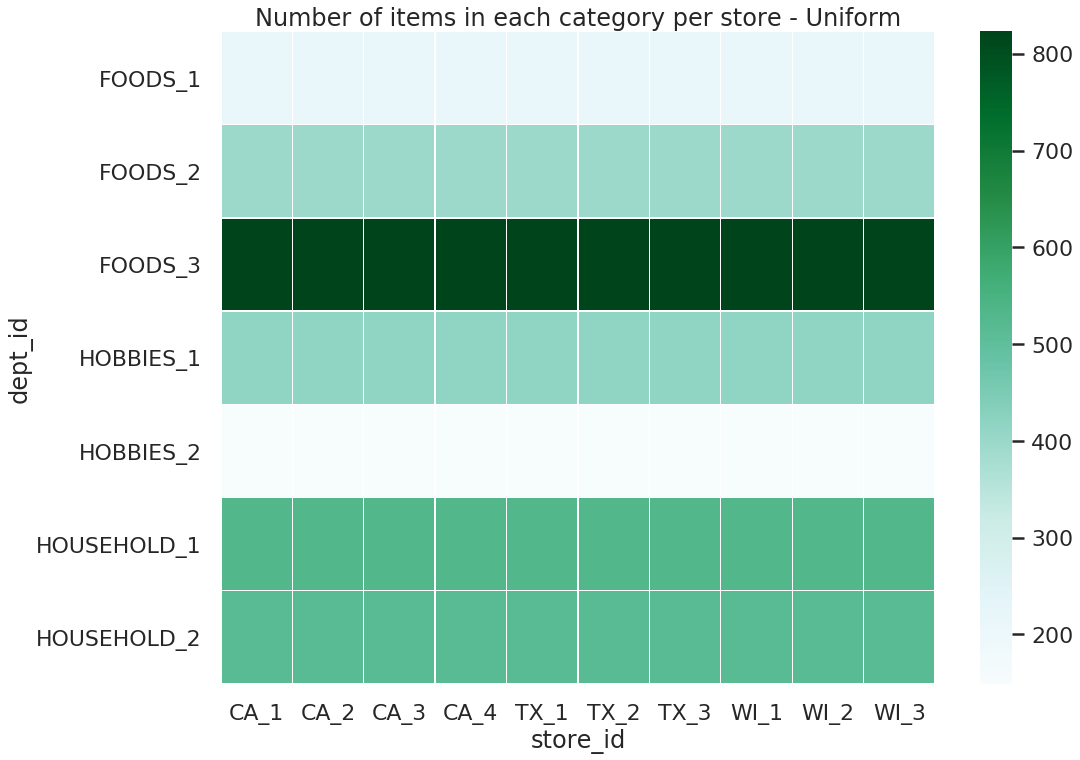

In [14]:
dept_storeloc_cross = pd.crosstab(train_sales['dept_id'], train_sales['store_id'])
print(dept_storeloc_cross)
ax = sns.heatmap(dept_storeloc_cross,
                linewidths = 0.4,
                cmap="BuGn")
ax.set(title = 'Number of items in each category per store - Uniform')

## Do total sales correlate with the number of items in a department? ##

Do departments sell more items simply because they HAVE more items to sell?  Or is there a weaker correlation?

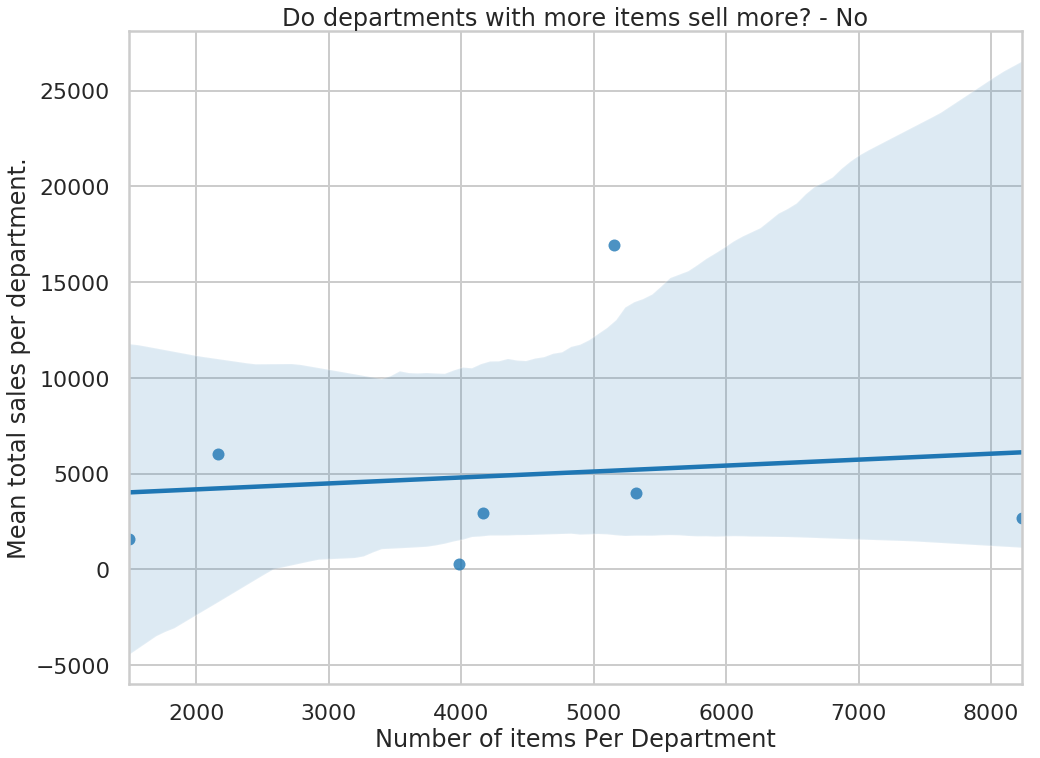

In [15]:
n_items_dept = train_sales['dept_id'].value_counts()
mean_of_total_sales_per_dept = dept_sum.mean(axis = 0)

ax = sns.regplot(n_items_dept, mean_of_total_sales_per_dept)
ax.set(title = 'Do departments with more items sell more? - No',
      xlabel = 'Number of items Per Department',
      ylabel = 'Mean total sales per department.')
plt.show()

## Do Sales Differ by Category? ##

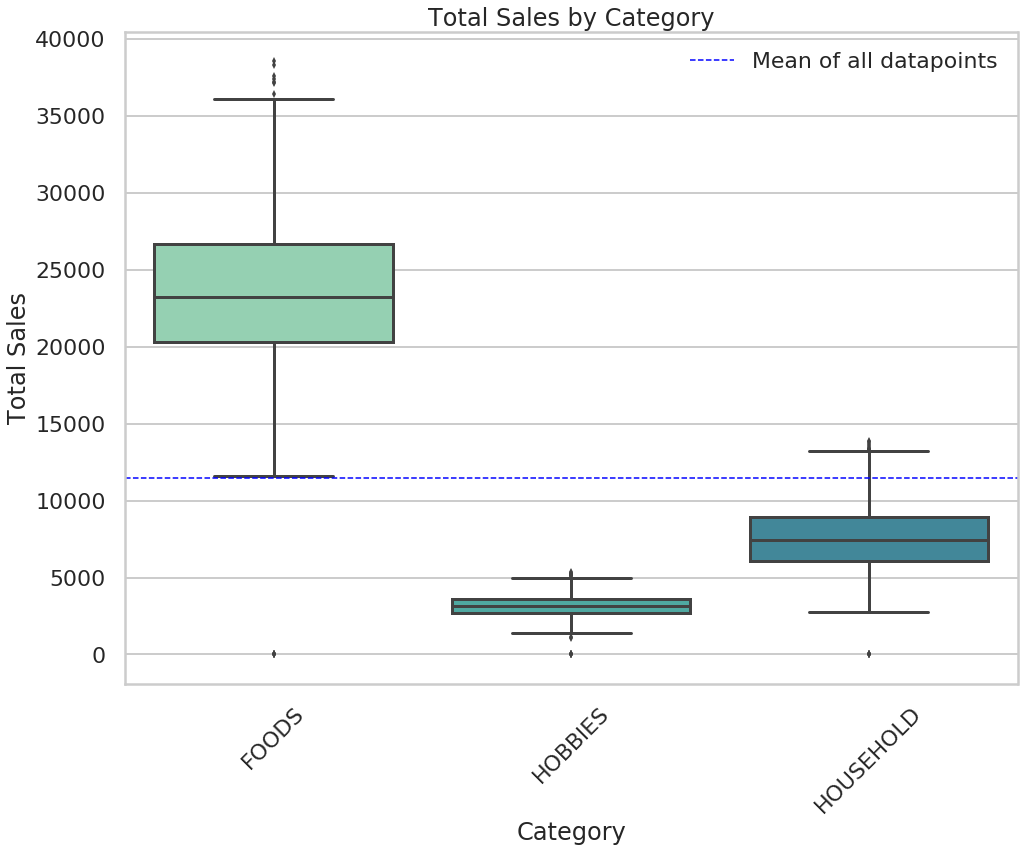

In [16]:
cat_sum = train_sales.groupby(['cat_id']).sum().T.reset_index(drop = True)
disp_boxplot(data = cat_sum, title = 'Total Sales by Category',
            xlabel = "Category", ylabel = "Total Sales")

## How do stores differ by State? ##

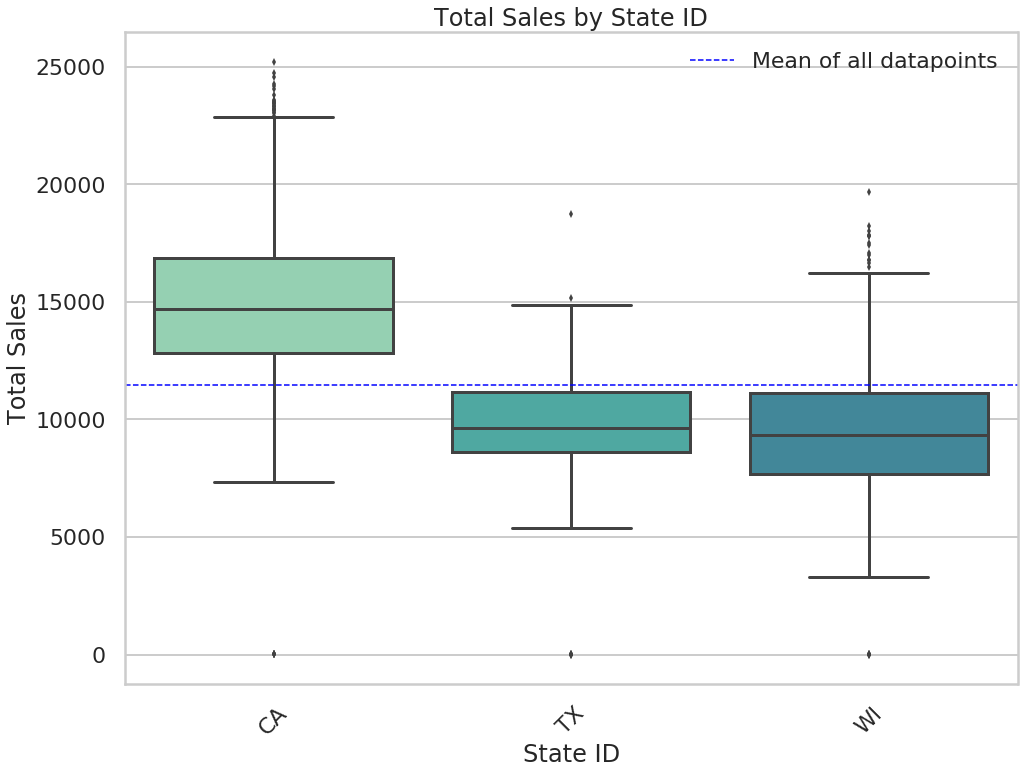

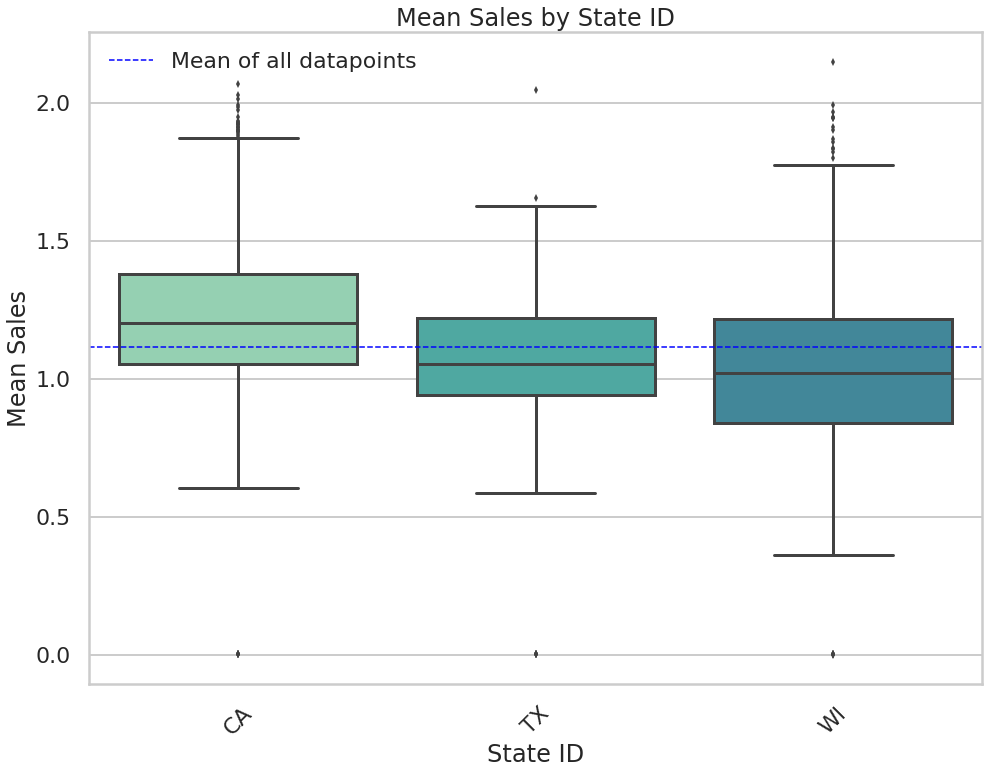

In [17]:
state_sum = train_sales.groupby(['state_id']).sum().T.reset_index(drop = True)
state_mean = train_sales.groupby(['state_id']).mean().T.reset_index(drop = True)

disp_boxplot(data = state_sum, title = 'Total Sales by State ID',
            xlabel = "State ID", ylabel = "Total Sales")

disp_boxplot(data = state_mean, title = 'Mean Sales by State ID',
            xlabel = "State ID", ylabel = "Mean Sales")

**Takeaways:**
* Since the mean sales are not significantly higher in CA, this may show that the total sales being higher in CA are simply due to there being 4 stores in the dataset instead of 3 like with TX and WI.

### How do SNAP days affect sales? ###


In [18]:
train_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## How do sales differ by store? ##

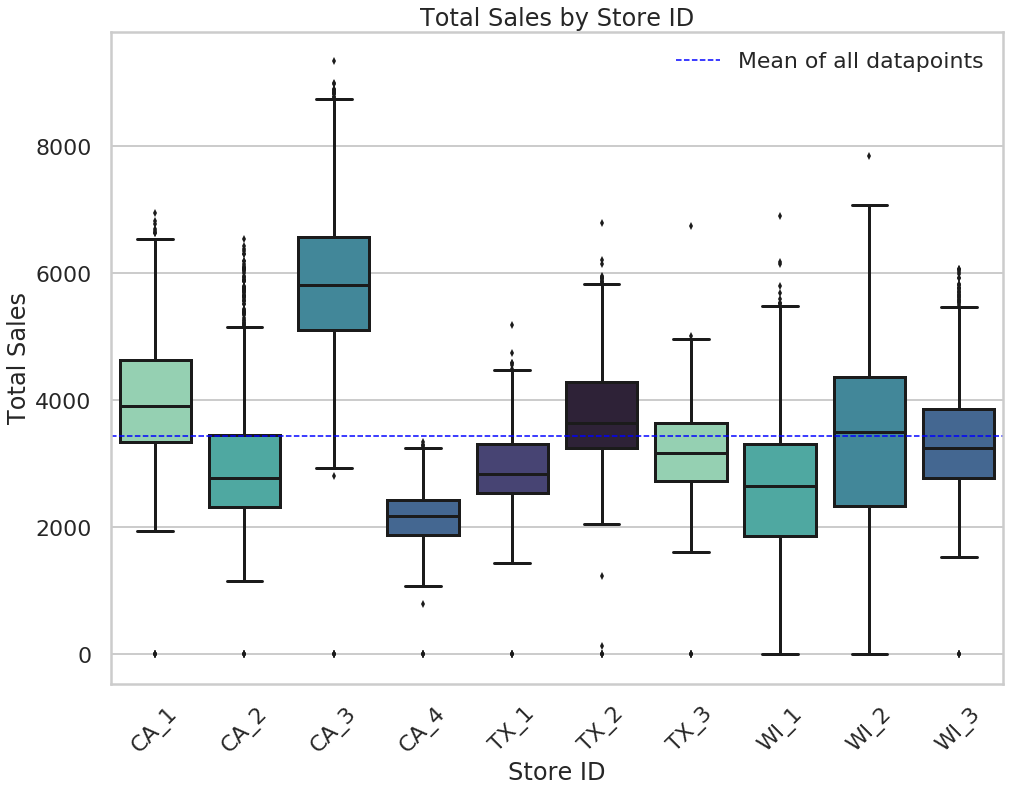

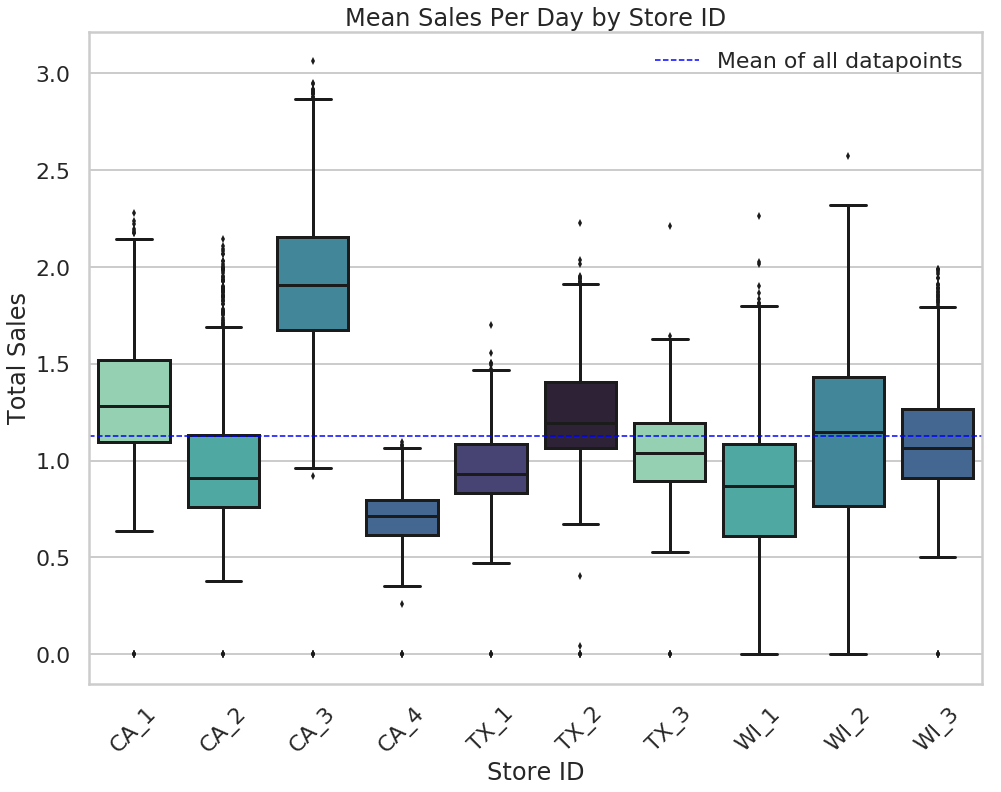

In [19]:
store_sum = train_sales.groupby(['store_id']).sum().T.reset_index(drop = True)
store_mean = train_sales.groupby(['store_id']).mean().T.reset_index(drop = True) 

disp_boxplot(data = store_sum, title = 'Total Sales by Store ID',
            xlabel = "Store ID", ylabel = "Total Sales")


disp_boxplot(data = store_mean, title = 'Mean Sales Per Day by Store ID',
            xlabel = "Store ID", ylabel = "Total Sales")

**Takeaways:**
* While CA_3 made the most sales, CA_2 was similar to other stores and CA_4 was fairly low.  Even though CA does have more overall mean sales, this may be because CA_3 is significantly higher than all the others.

## What is Hierarchical Data? ##

Hierarchical data refers to data being aggregated at different levels and scales.  

Knowing the data is hierarchical is important because it leads to a natural question - do the data tell us something different at different scales and hierarchies?


## Are there significant outliers on holidays and special days? ##
* In progress...

## Is there seasonality to the sales? ##

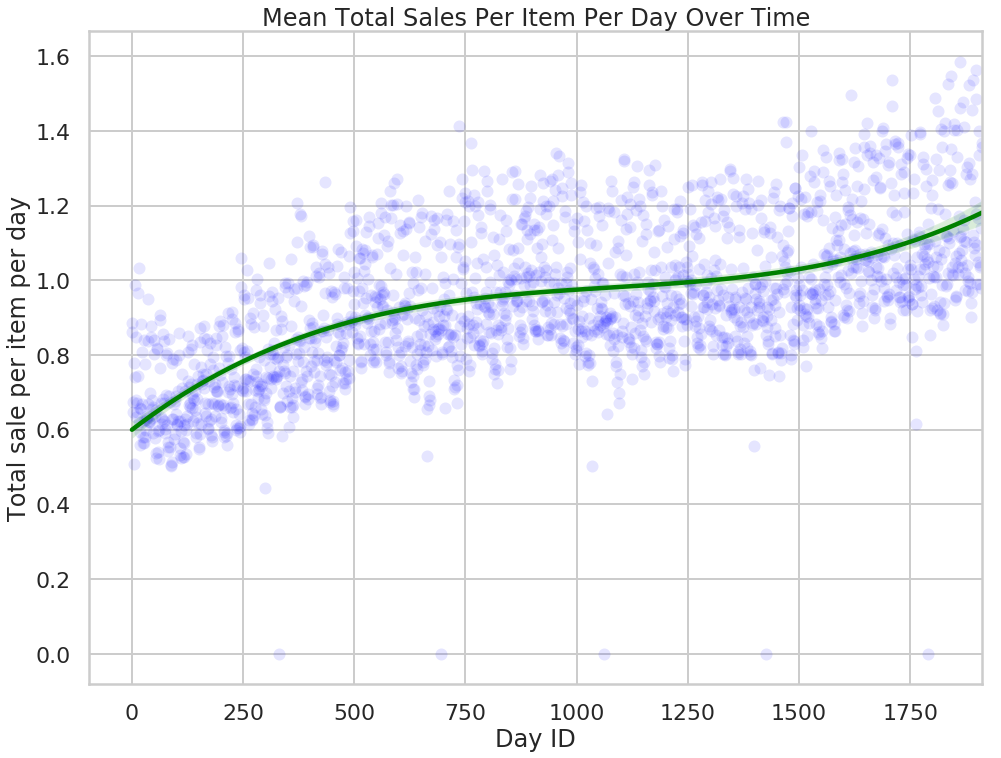

In [20]:
ax = sns.regplot(x = np.arange(dept_sales.shape[0]), y = dept_sales,
                 scatter_kws = {'color':'blue', 'alpha': 0.1},
                 order = 3, line_kws = {'color':'green'},)

ax.set(title = "Mean Total Sales Per Item Per Day Over Time",
      xlabel = 'Day ID', ylabel = 'Total sale per item per day')

plt.show()

**The dips are Christmas - the only day the store is closed** - Thanks https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda

## Seasonal Decomposition of One California Store: CA_1 ##

The seasonal decomposition shows how much a time series shows seaonality and trend.  It is a great way to think about how many sales are due to seaonality, trend, or one-off events like holidays.

We'll use a yearly frequency for now until we do a more detailed analysis.

### Yearly Cycle Decompose of CA_1 store ###

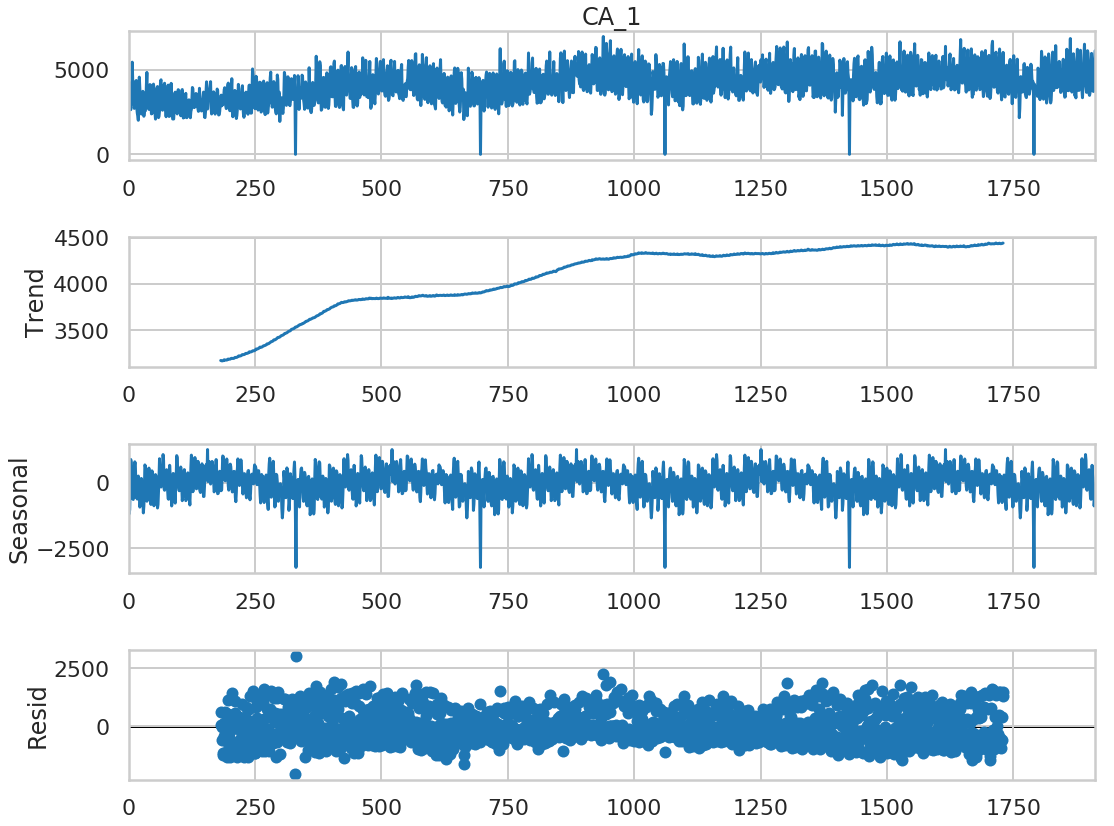

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
weeks_per_year = 365

time_series = store_sum["CA_1"]
sj_sc = seasonal_decompose(time_series, period = weeks_per_year)
sj_sc.plot()

plt.show()

1. ## Weekly cycle decompose of CA_1 store ##

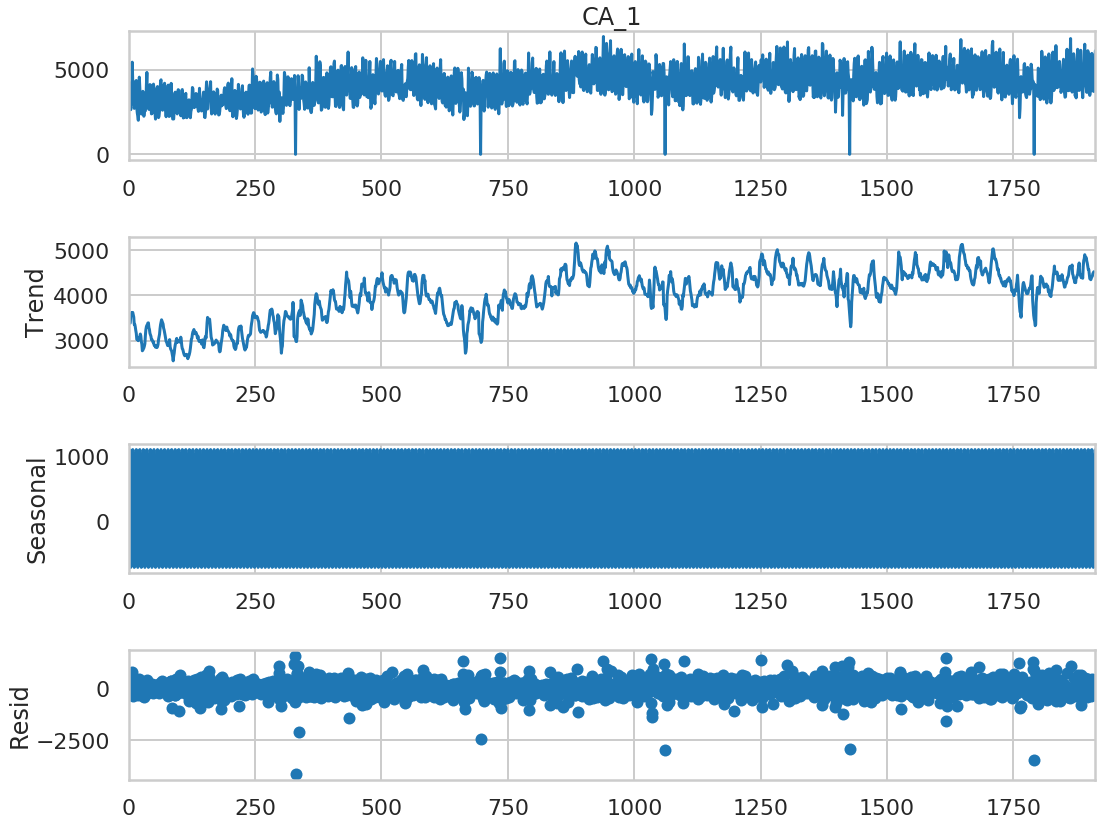

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
days_per_week = 7

time_series = store_sum["CA_1"]
sj_sc = seasonal_decompose(time_series, period = days_per_week)
sj_sc.plot()

plt.show()

## Baseline Sarima Model ##

Sarima models use both a moving average approach and an autorgressive approach to time series predictions.  To analyze time series, we must make the series stationary, which means modifying the series to remove its trend and keeping its variance constant.  As we saw above, there is variance and trend, so the SARIMA model has a parameter to take care of this for us (the d or diff parameter).  By taking the difference between each time step, we are able to make the time series stationary.

The SARIMA model seems to be doing extremely well, but it takes a very long time to do the predictions on a kaggle kernel.  I'm doing the processing of the SARIMA model offline.

After I work on Sarima optimizations, I will attempt to put this in ther Kernel, but due to time constraints I may need to keep it offline.

**Sarima helper function**

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_train_test(t_series, p = 2, d = 1, r = 2, NUM_TO_FORECAST = 56, do_plot_results = True):
    NUM_TO_FORECAST = NUM_TO_FORECAST  # Similar to train test splits.
    dates = np.arange(t_series.shape[0])

    model = SARIMAX(t_series, order = (p, d, r), trend = 'c')
    results = model.fit()
    results.plot_diagnostics(figsize=(18, 14))
    plt.show()

    forecast = results.get_prediction(start = -NUM_TO_FORECAST)
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()

    print(mean_forecast.shape)

    # Plot the forecast
    plt.figure(figsize=(14,16))
    plt.plot(dates[-NUM_TO_FORECAST:],
            mean_forecast.values,
            color = 'red',
            label = 'forecast')


    plt.plot(dates[-NUM_TO_FORECAST:],
            t_series.iloc[-NUM_TO_FORECAST:],
            color = 'blue',
            label = 'actual')
    plt.legend()
    plt.title('Predicted vs. Actual Values')
    plt.show()
    
    residuals = results.resid
    mae_sarima = np.mean(np.abs(residuals))
    print('Mean absolute error: ', mae_sarima)
    print(results.summary())


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


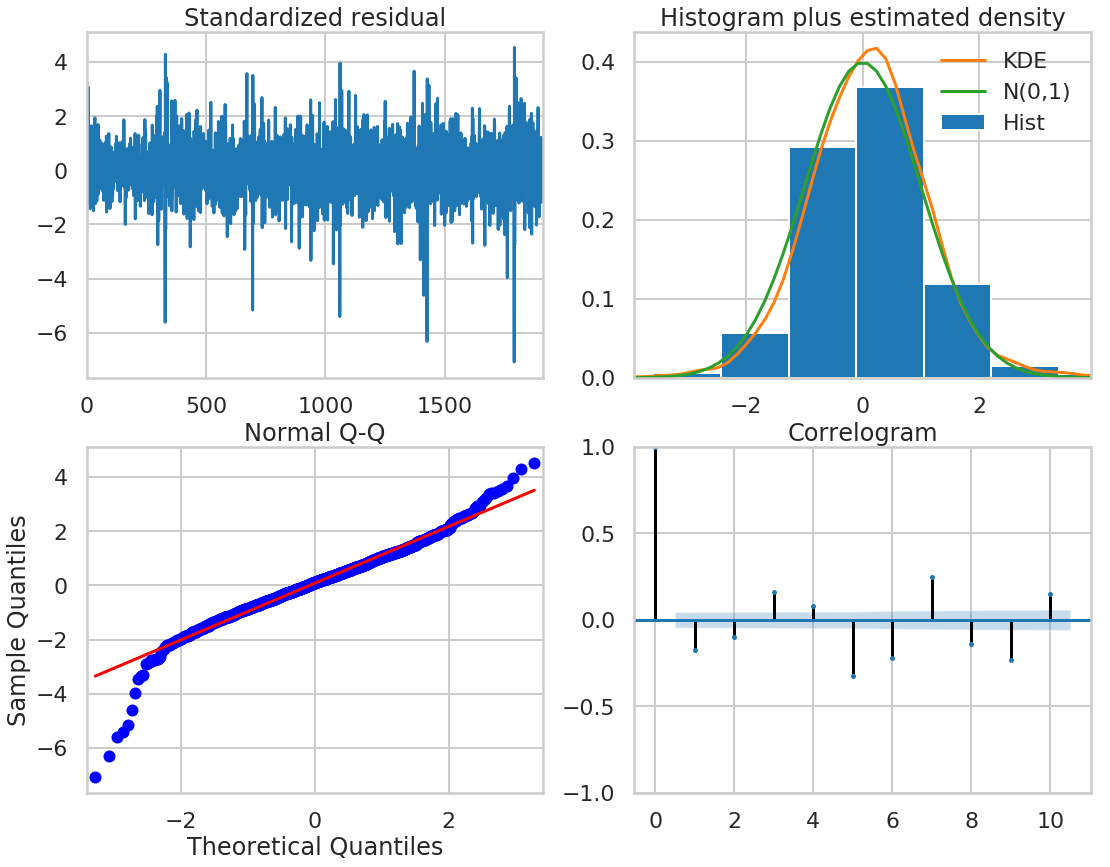

(56,)


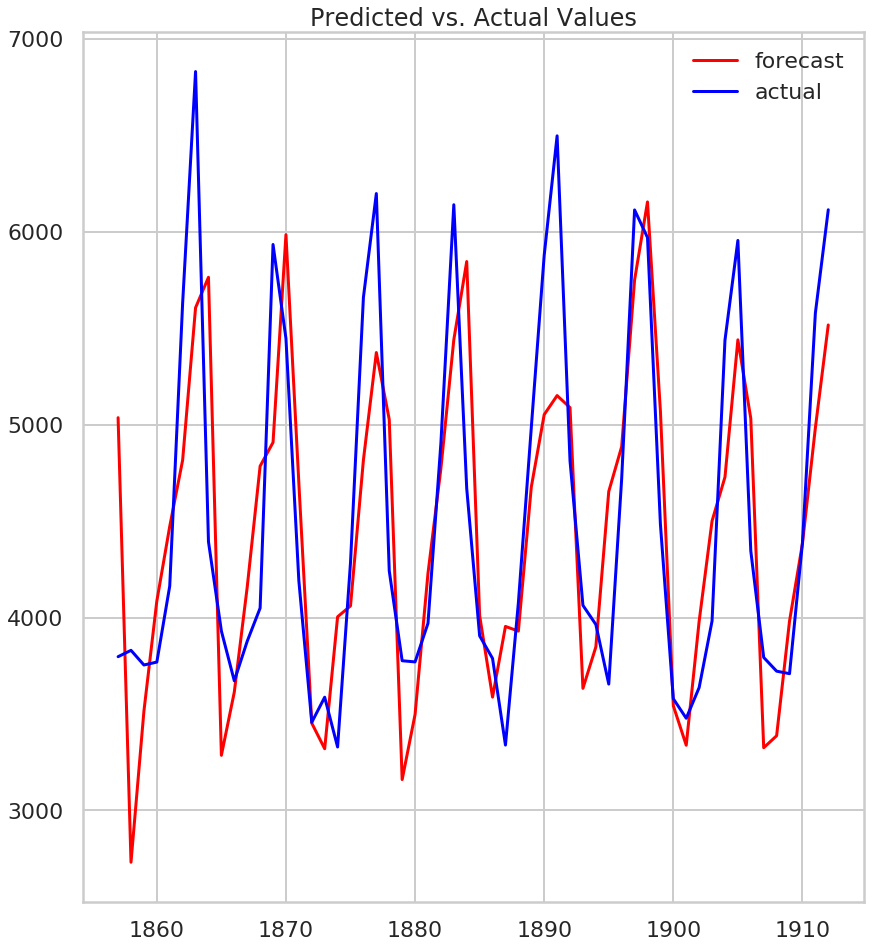

Mean absolute error:  462.93043296193645
                               SARIMAX Results                                
Dep. Variable:                   CA_1   No. Observations:                 1913
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -14983.618
Date:                Thu, 19 Mar 2020   AIC                          29979.236
Time:                        16:52:20   BIC                          30012.572
Sample:                             0   HQIC                         29991.504
                               - 1913                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -13.7017      3.869     -3.541      0.000     -21.285      -6.118
ar.L1          1.1871      0.012    103.051      0.000       1.164       1.210
ar.L2      

In [24]:
sarima_train_test(time_series)

* ## Sarima Predictions ##
* These were done offline in about 16 hours.  Uploaded here and will submit.  Basic strategy was the above cell.

In [25]:
USE_SARIMA_PREDS = True

In [26]:
if USE_SARIMA_PREDS:
    # Clean this code up.
    
    sarima_preds = pd.read_csv('/kaggle/input/m5-untuned-sarima-preds/Sarima_preds_submission.csv')
    sarima_preds[sarima_preds < 0] = 0  # Convert all negative numbers into 0.
    sarima_preds['id']= submission_file['id']
    
    # sarima_preds.to_csv('submission.csv', index = False)
    
    submission_df = sarima_preds
    
    #Cleaning
    submission_df = submission_df.iloc[:,:29]
    submission_df = submission_df.drop(['Unnamed: 0'], axis = 1)
    submission_df.index = submission_file['id']
    submission_df.reset_index(inplace = True)
    submission_df.columns = submission_file.columns
    submission_df.head()
    
    sarima_df = submission_df.copy()

## Understanding the Submission ##
* For those of you who haven't read "Heads or Tails"'s amazing kernel where the author explains this, [check it out here](https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda)

## Baseline Submissions - In Progress ##

I will be trying three baseline submissions:

* One will be a simple mean submission of sales on that day for that item throughout the last few years.

* One will be a tree regressor which will have to run a separate regression for each day.

* One will be a SARIMA prediction.  This is far easier, but takes very long to process for all the rows.


### Preparing the submission file ###
* This section is in progress.

In [27]:
train_sales.shape

(30490, 1919)

In [28]:
def subset_validation_set(df):
    is_validation_subset = df['id'].str.contains('validation')
    valid_subset = df[is_validation_subset]
    return valid_subset

def create_evaluation_rows(df):
    val_idx = df['id']
    

def prepare_submission_file(df, i, val_or_eval):
    ########################################################
    # This function does several things:
    #  It aggregates data from all the files and makes them
    #  inputtable to traditional ML algorithms, such as trees.
    
    #  It will output the a dataframe for each 'day'
    
    # Returns a submission_like dataframe that is ready to put
    # in an estimator.
    # Please cite and upvote this kernel if you use this code
    #########################################################
    
    # Extract the validation samples
    # valid_subset = subset_validation_set(df)
    valid_subset = df  # Fix this.
    
    # assert valid_subset.shape[0] == train_sales.shape[0], "The rows are not equal"
    
    # To do: validate the indices as well.
    
    # Collect date information 2016-04-25 to 2016-05-22 <-- The validation set days.
    # First denote which columns you care about.
    # + i is so that I can loop through to get all 28 dates.
    
    if val_or_eval == 'val':
        # Validation range: 2016-04-25 to 2016-05-22
        
        # d_87 - d_114
        i1 = 87 + i
        i1_str = "d_" + str(i1)

        # d_453 - d_480  <-- Leap year.  366 days after.
        i2 = 453 + i
        i2_str = "d_" + str(i2)

        # d_818 - d_845
        i3 = 818 + i
        i3_str = "d_" + str(i3)

        # d_1183 - d_1210
        i4 = 1183 + i
        i4_str = "d_" + str(i4)

        # d_1548 - d_1575
        i5 = 1548 + i
        i5_str = "d_" + str(i5)

        # d_1914 - d_1941  <-- Not in validation set
        # i6 = 1941 + i
        # i6_str = "d_" + str(i6)
        
    elif val_or_eval == 'eval':
        # Evaluation range: 2016-05-23 to 2016-06-19
        # d_87 - d_114
        eval_num_ahead = 28
        i1 = 87 + eval_num_ahead + i
        i1_str = "d_" + str(i1)

        # d_453 - d_480  <-- Leap year.  366 days after.
        i2 = 453 + eval_num_ahead + i
        i2_str = "d_" + str(i2)

        # d_818 - d_845
        i3 = 818 + eval_num_ahead + i
        i3_str = "d_" + str(i3)

        # d_1183 - d_1210
        i4 = 1183 + eval_num_ahead + i
        i4_str = "d_" + str(i4)

        # d_1548 - d_1575
        i5 = 1548 + eval_num_ahead + i
        i5_str = "d_" + str(i5)

        # d_1914 - d_1941  <-- Not in validation set
        # i6 = 1941 + eval_num_ahead + i
        # i6_str = "d_" + str(i6)
        
    
    all_important_days = [i1_str, i2_str, i3_str, i4_str, i5_str]
    col_names = ['this_day_1', 'this_day_2', 'this_day_3', 'this_day_4', 'this_day_5' ]
    
    # Extract the data from just these rows.
    important_days_subset = valid_subset[all_important_days]
    important_days_subset.columns = col_names
    
    # TO DO:
    # Rename them F1-F28?
    
    # Add the cost of the item.
    
    # create is_special_event
    
    # categorically encode special_event.
    
    # encode_is_snap
    
    return important_days_subset



### Baseline based on Means on the same day F1-F28 - Not Active ###
* This code did quite bad compared to the SARIMA model and is therefore going to be deactivated and erased.

In [29]:
DO_BASELINE_MEAN_PRED = False

In [30]:
if DO_BASELINE_MEAN_PRED:
    
    # Do a loop for every F_DAYNUM
    # Retrieve the information for that.
    # Create a submission based on that information.

    ####################################################
    # TO DO: CLEAN THIS UP.
    # Do the validation set.
    final_submission_df = train_sales.copy()
    final_cols = ['id']  # This will just be the columns we want in the final submission file.

    for i in tqdm(range(28)):

        important_days_df = prepare_submission_file(train_sales, i, val_or_eval = 'val')

        # Round or don't roud here?
        mean_of_days = important_days_df.mean(axis = 1)   # Shouldn't this be axis = 0?  Works only with ax = 1.

        this_col = "F" + (str(i + 1))
        final_cols.append(this_col)

        final_submission_df[this_col] = mean_of_days

    # Do the same thing for the evaluation set for now.
    # Update this later to include calendar and other information.

    ####################################################
    # Do the evaluation set.
    final_submission_df_eval = train_sales.copy()
    final_cols = ['id']
    for i in tqdm(range(28)):

        important_days_df_eval = prepare_submission_file(train_sales, i, val_or_eval = 'eval')

        mean_of_days = important_days_df_eval.mean(axis = 1)  # Shouldn't this be axis = 0?  Works only with ax = 1.

        this_col = "F" + (str(i + 1))
        final_cols.append(this_col)

        final_submission_df_eval[this_col] = mean_of_days

    final_submission_df_eval['id'] = final_submission_df_eval['id'].str.replace('validation', 'evaluation')

    # CONCATENATE THE VAL AND EVAL SETS
    submission_df = pd.concat([final_submission_df, final_submission_df_eval])

    def clean_submission_file(df):
        df = df[final_cols]
        return df
    
    mean_of_days_df = submission_df.copy()
    mean_of_days_df = clean_submission_file(mean_of_days_df)
    

In [31]:
if DO_BASELINE_MEAN_PRED:
    print(submission_df.shape)
    submission_df = clean_submission_file(submission_df)
    print(submission_df.shape)


In [32]:
if DO_BASELINE_MEAN_PRED:
    submission_df.head(5)

### Baseline with Tree Ensemble ###

We will be using the tidy dataframe tidy_df we created above to feed into this model.  Each row represents a distinct prediction, so this should go over well with regular model.


In [33]:
# Understanding the forecast metric.
# https://robjhyndman.com/papers/foresight.pdf

## Ensemble the above ##
* The mean submission dropped the ensemble quite a bit.  So just doing SARIMA prediction for now.

### Visualize sample rows of the submission predictions ###

In [34]:
submission_df.to_csv('submission.csv', index = False)
print(submission_df.shape)
print("Submission file created")

(60980, 29)
Submission file created


In [35]:
# For Viewing
eval_start = int(60980 / 2)
eval_head_end = eval_start + 2

submission_df.iloc[eval_start:eval_head_end, :]  # Take a look at the first few of the eval set.

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
30490,HOBBIES_1_001_CA_1_evaluation,0.991245,0.991032,0.949614,0.938247,0.910094,0.896034,0.871663,0.899121,0.846005,...,0.952158,0.951972,1.040769,0.935491,1.004970,0.958033,0.996898,1.053739,0.972604,1.021951
30491,HOBBIES_1_002_CA_1_evaluation,0.362567,0.381812,0.306682,0.284905,0.282658,0.265700,0.261064,0.247360,0.241468,...,0.165131,0.158827,0.153192,0.147423,0.142139,0.136837,0.233634,0.168026,0.148225,0.153566


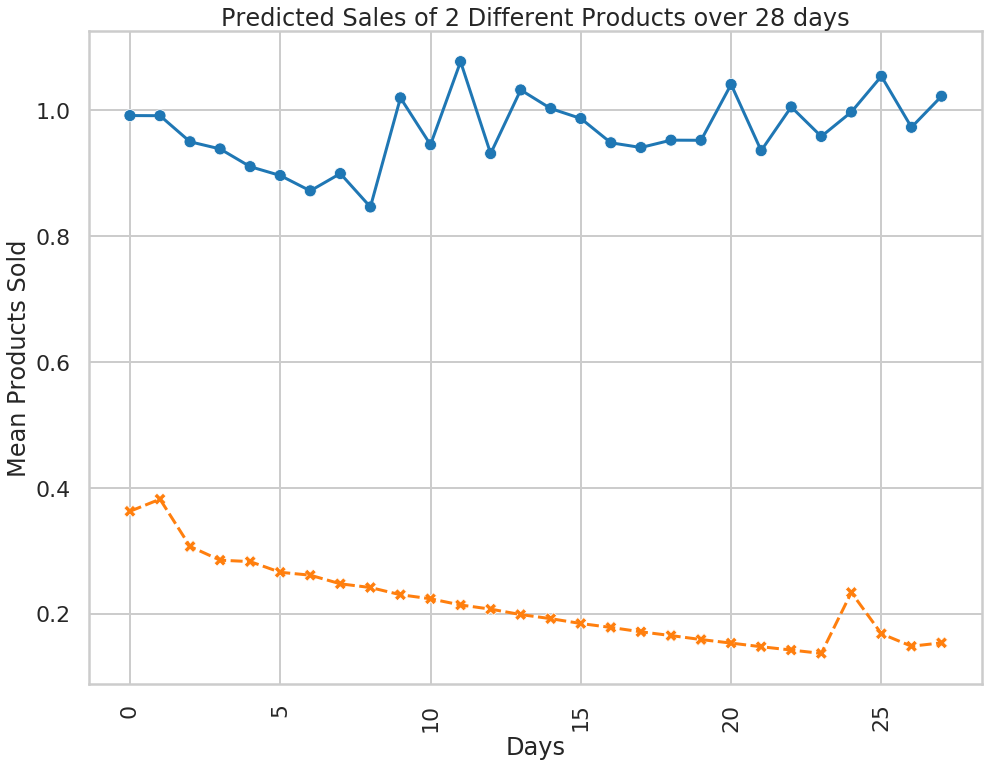

In [36]:
lineplot_data = submission_df.iloc[eval_start:eval_head_end, 1:].T
lineplot_data.index = range(len(lineplot_data.index))  # Clean up the F1 naming.

ax = sns.scatterplot(data = lineplot_data, legend = False)
ax2 = sns.lineplot(data = lineplot_data, legend = False)

ax.set(title = 'Predicted Sales of 2 Different Products over 28 days',
      xlabel = 'Days',
      ylabel = 'Mean Products Sold')

plt.xticks(rotation = 90)
plt.show()

### Thanks for reading - If you like my Kernel and want me to continue making my work public, let me know by upvoting and commenting.  It encourages me to continue making it visible to other Kagglers. ###